In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

luminex = pd.read_csv("../data/UpdatedLuminex.csv")
metadata = pd.read_csv("../data/Metadata_v2.csv")
df = pd.read_csv("../data/merged_filtered.csv")

In [2]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# data cleaning and preprocessing / feature engineering
df["Thal (n)"] = df["Thal"].str.split(" ").str[1].astype(int)

df["ABeta ratio"] = df["ABeta42 pg/ug"] / df["ABeta40 pg/ug"]
df["TAU ratio"] = df["pTAU pg/ug"] / df["tTAU pg/ug"]
education_order = [
    "High School",
    "Trade School/ Tech School",
    "Bachelors",
    "Graduate (PhD/Masters)",
    "Professional",
]
df["Highest level of education"] = pd.Categorical(
    df["Highest level of education"], categories=education_order, ordered=True
)
# condense into 2 groups, high school and post-secondary
df["Post-secondary"] = df["Highest level of education"].apply(
    lambda x: "High School" if x == "High School" else "Post-Secondary"
)
# condense into 2 groups, e4+ and e4-
df["APOE Genotype 4"] = df["APOE Genotype"].apply(
    lambda x: "e4+" if "4" in x else "e4-"
)

In [3]:
# define x and y for analysis
x = "Post-secondary"
y = "TAU ratio"

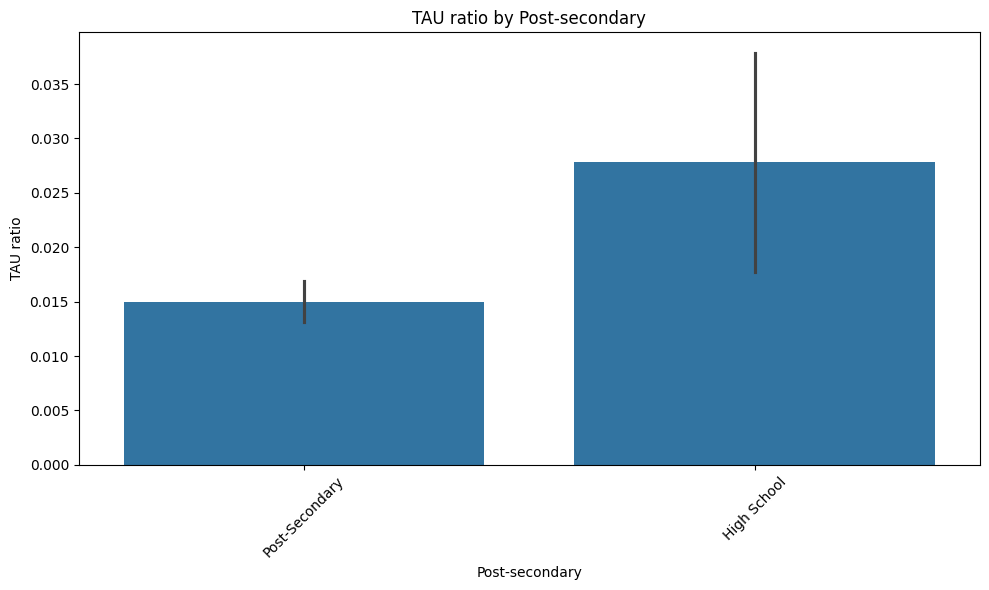

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=x, y=y, errorbar="se")
plt.ylabel(y)
plt.xlabel(x)
plt.title(f"{y} by {x}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# t-test between the two groups
from scipy import stats
group1_name = "High School"
group2_name = "Post-Secondary"

group1 = df[df[x] == group1_name][y].dropna()
group2 = df[df[x] == group2_name][y].dropna()

t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-test between {group1_name} and {group2_name} for {y}: t-statistic = {t_stat}, p-value = {p_value}")

T-test between High School and Post-Secondary for TAU ratio: t-statistic = 2.033778045320868, p-value = 0.04524761826063113


In [ ]:
# run ANOVA for every group in x
try:
    model = ols(f'Q("{y}") ~ Q("{x}")', data=df).fit()
except Exception as e:
    print("likely bad columns specified")
    print(f"Error in model fitting: {e}")
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq    df         F    PR(>F)
Q("Post-secondary")  0.002314   1.0  4.136253  0.045248
Residual             0.045311  81.0       NaN       NaN


In [9]:
# run Tukey's HSD test for post-hoc analysis (anova)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df[y], groups=df[x], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2     meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
High School Post-Secondary  -0.0128 0.0452 -0.0253 -0.0003   True
-----------------------------------------------------------------
